In [29]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.17.0


In [30]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-68y30tvt
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-68y30tvt
  Resolved https://github.com/tensorflow/docs to commit 460419a6369bd00bfc3ce7a7c92b0ca2a832c91b
  Preparing metadata (setup.py) ... done


In [31]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [32]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [33]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [34]:
FEATURES = 28

In [35]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [36]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [37]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


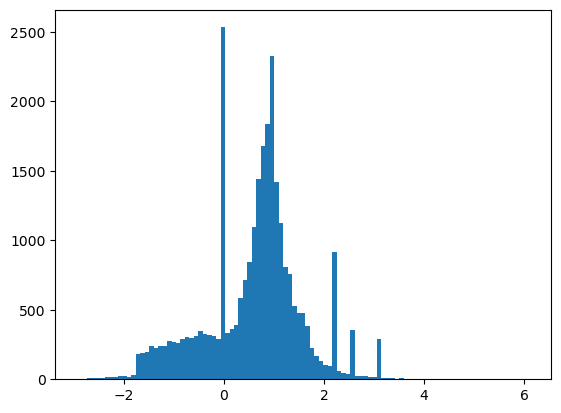

In [38]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [39]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [40]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [41]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [42]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

# Traning Procedure

In [43]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

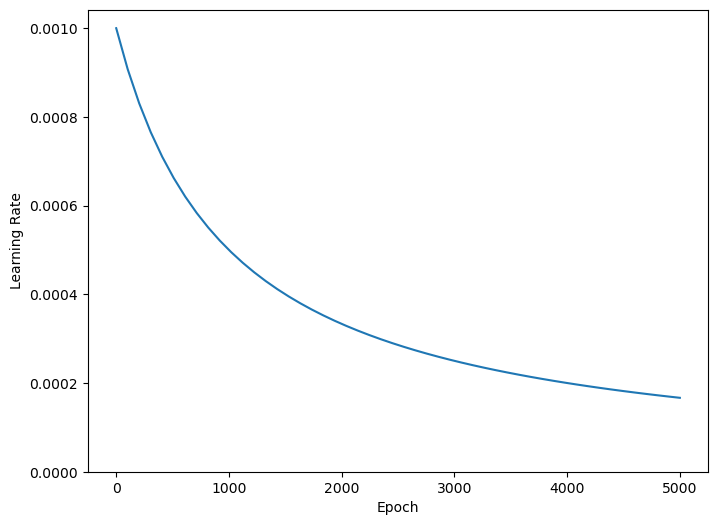

In [44]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [45]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [46]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [47]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [48]:
size_histories = {}

In [49]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4843,  binary_crossentropy:0.8334,  loss:0.8334,  val_accuracy:0.4820,  val_binary_crossentropy:0.7816,  val_loss:0.7816,  
......

2024-08-10 22:07:27.237779: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:27.237839: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:27.280823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:27.280869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:27.315693: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:27.315739: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:27.354224: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:27.459245: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:27.459296: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:27.495585: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:27.495633: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:27.531150: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:27.531176: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:27.568912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:27.669254: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:27.669284: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:27.703683: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:27.703711: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:27.738514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:27.738553: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:27.774673: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:27.881660: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:27.916538: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:27.916588: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:27.952958: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:27.953001: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:27.986926: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:27.986958: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

......

2024-08-10 22:07:28.092730: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:28.092775: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:28.128844: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:28.128871: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:28.162520: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:28.162548: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:28.196239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:28.296802: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:28.296831: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:28.329247: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:28.329278: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:28.364991: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:28.365040: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:28.397198: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:28.499390: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:28.499416: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:28.534373: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:28.534400: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:28.570118: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:28.570156: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:28.602537: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:28.703629: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:28.736410: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:28.736442: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:28.772736: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:28.772770: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:28.839145: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:28.872695: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

......

2024-08-10 22:07:28.905575: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:28.905602: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:28.937157: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:28.937184: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:28.970859: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:29.003449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:29.003500: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

........

2024-08-10 22:07:29.138447: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:29.138478: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:29.173019: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:29.206665: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:29.240142: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:29.271799: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:29.271827: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv it

.......

2024-08-10 22:07:29.369196: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:29.369225: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:29.402246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:29.402275: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:29.435336: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:29.435369: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:29.470359: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:29.601245: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:29.601276: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:29.634418: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:29.634460: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:29.668644: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:29.668677: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:29.737157: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:29.808053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:29.808089: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:29.840653: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:29.840694: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:29.873908: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:29.873943: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:29.906213: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:30.042470: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:30.042507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:30.077232: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:30.077262: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:30.109386: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:30.109436: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:30.142864: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:30.276394: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:30.276442: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:30.307889: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:30.307926: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:30.341875: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:30.341904: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:30.377424: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....
Epoch: 100, accuracy:0.5994,  binary_crossentropy:0.6272,  loss:0.6272,  val_accuracy:0.5880,  val_binary_crossentropy:0.6208,  val_loss:0.6208,  
..

2024-08-10 22:07:30.512143: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:30.512185: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:30.544333: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:30.544380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:30.576535: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:30.576564: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:30.609344: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:30.714291: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:30.714339: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:30.750530: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:30.750560: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:30.787460: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:30.787486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:30.820044: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:30.917078: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:30.917116: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:30.946873: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:30.946912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:30.982418: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:30.982448: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:31.013047: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:31.142458: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:31.142507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:31.176926: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:31.176953: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:31.207668: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:31.240811: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:31.240855: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

......

2024-08-10 22:07:31.369404: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:31.369444: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:31.401915: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:31.401954: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:31.442740: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:31.442768: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:31.475665: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:31.577060: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:31.577089: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:31.610032: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:31.610066: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:31.644815: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:31.644844: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:31.684019: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:31.783748: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:31.783778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:31.816541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:31.816570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:31.846414: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:31.846443: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:31.879791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:32.014218: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:32.014277: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:32.045995: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:32.046024: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:32.080419: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:32.080460: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:32.113814: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:32.249001: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:32.249034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:32.283757: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:32.283785: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:32.317217: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:32.317250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:32.352248: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:32.483603: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:32.483632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:32.514453: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:32.514504: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:32.544519: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:32.544569: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:32.577246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:32.716628: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:32.716699: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:32.788792: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:32.788817: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:32.822571: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:32.822600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:32.855286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:32.925412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:32.925461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:32.959496: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:32.959525: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:32.993643: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:32.993673: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:33.024699: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

........

2024-08-10 22:07:33.156766: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:33.156816: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:33.189857: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:33.189916: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:33.221906: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:33.221938: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:33.251691: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:33.379557: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:33.379586: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:33.415479: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:33.415509: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:33.448736: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:33.481928: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:33.481963: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.......

2024-08-10 22:07:33.615438: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:33.615468: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:33.648148: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:33.648205: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:33.682721: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:33.682767: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:33.716999: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....
Epoch: 200, accuracy:0.6322,  binary_crossentropy:0.6105,  loss:0.6105,  val_accuracy:0.6340,  val_binary_crossentropy:0.6014,  val_loss:0.6014,  
.

2024-08-10 22:07:33.825340: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:33.858648: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:33.858675: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:33.892156: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:33.892186: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:33.924946: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:33.924975: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.......

2024-08-10 22:07:34.061004: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:34.061029: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:34.095970: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:34.096002: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:34.129598: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:34.162138: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:34.162168: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

......

2024-08-10 22:07:34.266435: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:34.266476: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:34.301201: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:34.301229: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:34.333681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:34.333708: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:34.365726: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:34.471006: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:34.471034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:34.507396: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:34.507423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:34.541151: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:34.541182: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:34.574618: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:34.679262: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:34.679306: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:34.712974: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:34.713006: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:34.745698: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:34.745727: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:34.779171: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:34.922233: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:34.922267: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:34.955054: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:34.955087: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:34.991134: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:34.991161: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:35.024049: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:35.130602: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:35.130645: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:35.164722: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:35.164770: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:35.199067: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:35.199106: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:35.231953: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:35.333508: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:35.333537: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:35.368145: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:35.368174: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:35.400548: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:35.400576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:35.434143: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:35.539600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:35.539633: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:35.574431: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:35.574479: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:35.610030: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:35.610059: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:35.642867: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:35.745896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:35.745943: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:35.781539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:35.781584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:35.816756: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:35.816795: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:35.848989: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:35.949924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:35.949954: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:35.985893: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:35.985920: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:36.022654: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:36.022682: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:36.056767: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:36.158058: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:36.158084: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:36.191569: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:36.191595: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:36.224904: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:36.224931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:36.257246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:36.390922: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:36.390949: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:36.424370: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:36.424398: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:36.455397: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:36.455433: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:36.491121: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:36.622057: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:36.622104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:36.654614: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:36.654641: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:36.689594: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:36.689624: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:36.722272: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:36.829214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:36.829240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:36.858964: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:36.859003: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:36.889230: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:36.889258: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:36.961750: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:37.073787: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:37.073821: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:37.112830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:37.148881: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:37.148924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:37.183611: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:37.183642: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

....
Epoch: 300, accuracy:0.6502,  binary_crossentropy:0.5981,  loss:0.5981,  val_accuracy:0.6600,  val_binary_crossentropy:0.5919,  val_loss:0.5919,  
..

2024-08-10 22:07:37.296314: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:37.296341: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:37.331518: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:37.331548: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:37.370250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:37.370294: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:37.405725: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:37.512887: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:37.512914: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:37.547975: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:37.548006: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:37.582795: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:37.582827: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:37.619745: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:37.721612: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:37.721658: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:37.753917: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:37.753946: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:37.786807: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:37.786833: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:37.819980: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:37.948869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:37.948902: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:37.982018: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:37.982046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:38.017332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:38.017360: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:38.052723: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:38.154804: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:38.154831: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:38.187496: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:38.187521: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:38.221680: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:38.221724: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:38.255595: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:38.357467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:38.357513: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:38.389992: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:38.390040: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:38.423243: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:38.423288: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:38.455545: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:38.582492: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:38.582540: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:38.615771: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:38.615800: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:38.649632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:38.649664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:38.682686: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:38.815911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:38.815938: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:38.851682: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:38.851711: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:38.884969: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:38.884998: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:38.921493: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:39.023529: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:39.023557: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:39.055288: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:39.055316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:39.090366: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:39.090396: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:39.123393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:39.258744: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:39.258773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:39.293672: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:39.293698: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:39.329708: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:39.329755: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:39.362870: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:39.467028: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:39.467062: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:39.500592: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:39.500640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:39.534181: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:39.534228: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:39.563906: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:39.693876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:39.693904: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:39.730531: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:39.730570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:39.761829: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:39.761874: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:39.793919: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:39.931156: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:39.931203: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:39.965211: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:39.965259: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:39.997486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:39.997516: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:40.035680: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:40.138972: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:40.139001: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:40.172321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:40.172358: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:40.208278: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:40.208309: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:40.242670: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:40.343818: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:40.343845: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:40.375826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:40.375860: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:40.406973: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:40.407002: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:40.439236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:40.577166: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:40.577209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:40.608714: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:40.608742: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:40.687076: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:40.687106: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:40.722552: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.
Epoch: 400, accuracy:0.6588,  binary_crossentropy:0.5920,  loss:0.5920,  val_accuracy:0.6630,  val_binary_crossentropy:0.5890,  val_loss:0.5890,  
.....

2024-08-10 22:07:40.790834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:40.790860: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:40.822946: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:40.855345: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:40.855388: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:40.886933: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:40.886971: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.......

2024-08-10 22:07:41.024055: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:41.024091: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:41.059226: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:41.059256: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:41.092774: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:41.092818: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:41.125704: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:41.226767: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:41.226822: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:41.260219: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:41.260269: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:41.295350: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:41.295380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:41.327876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:41.434337: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:41.434376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:41.466423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:41.466449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:41.500590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:41.500621: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:41.537223: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:41.644608: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:41.644649: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:41.680058: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:41.680107: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:41.713452: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:41.713490: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:41.748309: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:41.878772: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:41.878805: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:41.911791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:41.911826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:41.946407: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:41.946455: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:41.979564: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:42.082393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:42.082421: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:42.118515: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:42.118546: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:42.155959: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:42.155988: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:42.187921: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:42.286410: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:42.286434: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:42.324750: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:42.324798: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:42.361426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:42.361457: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:42.395211: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:42.498035: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:42.498066: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:42.535159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:42.535186: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:42.570037: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:42.570071: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:42.603524: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:42.703637: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:42.703665: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:42.736316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:42.736347: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:42.769904: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:42.769939: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:42.802693: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:42.935712: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:42.935777: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:42.970039: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:42.970073: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:43.004056: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:43.004105: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:43.036380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:43.144860: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:43.144908: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:43.182540: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:43.182569: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:43.215763: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:43.215794: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:43.249051: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:43.348594: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:43.348623: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:43.383546: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:43.383590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:43.416486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:43.416537: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:43.451518: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:43.552183: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:43.552212: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:43.583441: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:43.583481: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:43.614713: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:43.614761: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:43.647848: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:43.772283: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:43.772332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:43.805566: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:43.805595: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:43.838552: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:43.838598: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:43.875217: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:43.983143: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:43.983168: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:44.017808: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:44.017844: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:44.051612: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:44.085646: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:44.085675: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.
Epoch: 500, accuracy:0.6613,  binary_crossentropy:0.5883,  loss:0.5883,  val_accuracy:0.6720,  val_binary_crossentropy:0.5864,  val_loss:0.5864,  
.....

2024-08-10 22:07:44.184094: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:44.217122: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:44.217174: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:44.252592: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:44.252640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:44.288123: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:44.288177: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:44.394043: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:44.394090: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:44.429436: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:44.429466: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:44.465168: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:44.465195: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:44.498933: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:44.598970: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:44.598997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:44.632205: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:44.632232: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:44.664733: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:44.664766: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:44.695747: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:44.802621: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:44.802647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:44.839917: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:44.839947: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:44.873277: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:44.873307: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:44.907107: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:45.017441: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:45.017472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:45.050307: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:45.050357: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:45.082555: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:45.082594: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:45.119071: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:45.219918: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:45.219949: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:45.253596: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:45.253634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:45.285598: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:45.285623: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:45.317924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:45.428744: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:45.428791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:45.464247: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:45.464298: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:45.498556: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:45.498585: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:45.529242: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:45.665974: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:45.666004: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:45.698702: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:45.698732: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:45.731525: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:45.731553: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:45.766861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:45.868420: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:45.868445: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:45.901540: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:45.901570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:45.933861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:45.933890: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:45.971784: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:46.074883: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:46.074921: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:46.108930: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:46.108971: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:46.139397: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:46.139425: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:46.171465: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:46.301104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:46.301147: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:46.333890: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:46.333919: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:46.368619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:46.368646: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:46.410667: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:46.514663: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:46.514693: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:46.548849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:46.548888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:46.583479: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:46.617584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:46.617614: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.......

2024-08-10 22:07:46.749569: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:46.749618: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:46.784592: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:46.784639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:46.819229: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:46.819257: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:46.852687: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:46.961108: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:46.961138: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:46.995117: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:47.028234: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:47.028282: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:47.060757: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:47.060786: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

......

2024-08-10 22:07:47.163635: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:47.163659: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:47.202332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:47.202361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:47.234019: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:47.234068: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:47.265751: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:47.371304: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:47.371356: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:47.405448: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:47.405476: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:47.439071: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:47.439113: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:47.472683: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

..
Epoch: 600, accuracy:0.6667,  binary_crossentropy:0.5853,  loss:0.5853,  val_accuracy:0.6650,  val_binary_crossentropy:0.5867,  val_loss:0.5867,  
....

2024-08-10 22:07:47.573806: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:47.573845: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:47.607221: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:47.607252: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:47.640083: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:47.640137: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:47.675408: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

........

2024-08-10 22:07:47.806542: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:47.806573: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:47.836042: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:47.836075: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:47.869558: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:47.900968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:47.900997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

......

2024-08-10 22:07:48.032723: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:48.032750: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:48.066616: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:48.066662: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:48.101067: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:48.101106: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:48.133598: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:48.237306: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:48.237338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:48.270976: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:48.271008: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:48.305515: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:48.305567: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:48.336488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:48.463687: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:48.463734: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:48.495592: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:48.495642: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:48.528101: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:48.528155: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:48.566718: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:48.694998: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:48.695036: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:48.724745: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:48.724777: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:48.753985: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:48.754012: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:48.787185: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:48.916692: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:48.916725: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:48.949806: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:48.949835: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:48.983421: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:48.983457: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:49.016321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:49.138761: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:49.138793: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:49.172130: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:49.172173: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:49.203873: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:49.203927: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:49.236162: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:49.361525: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:49.361554: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:49.395861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:49.395912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:49.428023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:49.428079: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:49.458681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:49.587745: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:49.587771: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:49.618380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:49.618413: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:49.649376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:49.649405: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:49.682157: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:49.808907: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:49.808950: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:49.841971: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:49.872142: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:49.872176: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:49.903921: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:49.932798: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.......

2024-08-10 22:07:50.036657: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:50.036683: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:50.068626: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:50.068656: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:50.101050: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:50.101079: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:50.133492: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:50.262622: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:50.262665: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:50.297501: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:50.297532: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:50.328760: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:50.328814: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:50.362797: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:50.497682: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:50.497729: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:50.530118: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:50.530170: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:50.562751: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:50.562783: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:50.597448: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......
Epoch: 700, accuracy:0.6703,  binary_crossentropy:0.5832,  loss:0.5832,  val_accuracy:0.6560,  val_binary_crossentropy:0.5873,  val_loss:0.5873,  
.

2024-08-10 22:07:50.731233: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:50.731265: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:50.763876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:50.763929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:50.798549: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:50.798597: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:50.831115: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:50.961686: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:50.961735: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:50.993717: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:50.993746: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:51.026837: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:51.026866: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:51.057166: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:51.166270: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:51.166319: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:51.203190: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:51.203240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:51.235014: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:51.235065: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:51.269408: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:51.398755: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:51.398804: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:51.430782: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:51.430809: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:51.465190: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:51.465236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:51.499756: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

........

2024-08-10 22:07:51.632492: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:51.632532: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:51.665515: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:51.665564: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:51.699213: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:51.699258: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:51.733033: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:51.860101: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:51.860159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:51.893565: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:51.893599: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:51.924063: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:51.955092: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:51.955138: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.......

2024-08-10 22:07:52.091113: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:52.091153: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:52.126061: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:52.157938: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:52.157985: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:52.191332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:52.191370: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

......

2024-08-10 22:07:52.320128: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:52.320158: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:52.353743: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:52.353823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:52.388179: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:52.388210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:52.423647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:52.526972: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:52.527020: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:52.561558: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:52.561599: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:52.595025: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:52.595064: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:52.632662: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:52.733659: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:52.733688: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:52.767104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:52.767152: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:52.799691: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:52.799729: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:52.831639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:52.941906: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:52.941934: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:52.979759: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:52.979789: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:53.015526: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:53.049541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:53.049581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.......

2024-08-10 22:07:53.186636: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:53.186665: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:53.223099: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:53.254529: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:53.254584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:53.288540: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:53.288566: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

......

2024-08-10 22:07:53.391403: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:53.391429: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:53.424791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:53.424834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:53.459538: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:53.459580: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:53.491045: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:53.627420: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:53.627450: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:53.697097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:53.697125: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:53.730023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:53.730054: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:53.762122: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

........

2024-08-10 22:07:53.859046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:53.859079: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:53.892352: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:53.892382: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:53.957356: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:53.957385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:53.990023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....
Epoch: 800, accuracy:0.6708,  binary_crossentropy:0.5815,  loss:0.5815,  val_accuracy:0.6660,  val_binary_crossentropy:0.5857,  val_loss:0.5857,  
.

2024-08-10 22:07:54.090780: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:54.090808: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:54.123958: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:54.123991: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:54.157267: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:54.157298: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:54.190146: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:54.324780: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:54.324810: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:54.358236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:54.358265: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:54.392143: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:54.392194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:54.426908: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:54.528514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:54.528544: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:54.563939: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:54.563985: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:54.599246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:54.631126: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:54.631153: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

......

2024-08-10 22:07:54.737685: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:54.737730: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:54.775459: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:54.775491: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:54.809220: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:54.809249: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:54.852629: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:54.955456: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:54.955484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:54.988870: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:54.988907: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:55.024517: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:55.024549: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:55.055723: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:55.163426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:55.163475: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:55.200868: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:55.200897: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:55.235675: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:55.235703: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:55.268007: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:55.375053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:55.375090: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:55.410347: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:55.410379: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:55.444611: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:55.444641: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:55.476858: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:55.582620: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:55.582666: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:55.617286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:55.617318: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:55.652664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:55.652690: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:55.720132: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:55.825783: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:55.825814: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:55.859172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:55.859213: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:55.894756: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:55.894788: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:55.927344: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:56.027993: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:56.028020: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:56.061633: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:56.061663: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:56.098367: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:56.098405: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:56.131081: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:56.230843: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:56.230869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:56.264925: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:56.264957: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:56.294817: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:56.294855: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:56.331169: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:56.463697: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:56.498577: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:56.498605: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:56.529746: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:56.529775: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:56.562367: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:56.596211: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.......

2024-08-10 22:07:56.668106: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:56.668157: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:56.700473: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:56.700504: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:56.734455: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:56.734504: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:56.763215: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:56.896097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:56.896127: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:56.931161: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:56.931210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:56.962939: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:56.962986: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:56.995455: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:57.129489: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:57.129519: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:57.160234: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:57.160272: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:57.191079: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:57.191118: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:57.223872: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

........

2024-08-10 22:07:57.363660: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:57.363693: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:57.397156: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:57.397185: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:57.430362: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:57.430413: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:57.460052: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

..
Epoch: 900, accuracy:0.6739,  binary_crossentropy:0.5789,  loss:0.5789,  val_accuracy:0.6590,  val_binary_crossentropy:0.5864,  val_loss:0.5864,  
....

2024-08-10 22:07:57.590752: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:57.590786: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:57.625418: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:57.625458: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:57.660877: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:57.660925: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:57.692743: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:57.793445: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:57.793471: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:57.827318: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:57.827348: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:57.861540: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:57.861570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:57.891819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:58.026037: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:58.026071: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:58.058266: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:58.058292: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:58.090300: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:58.090348: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:58.122839: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:58.257654: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:58.257683: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:58.290404: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:58.290442: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:58.322008: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:58.355068: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:58.355100: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.......

2024-08-10 22:07:58.492170: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:58.492204: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:58.526774: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:58.526802: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:58.557696: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:58.557727: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:58.589353: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:58.726468: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-10 22:07:58.726501: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:58.726510: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:58.761730: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:58.761832: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:58.798462: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:58.798528: I tensorflow/cor

......

2024-08-10 22:07:58.933154: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:58.933203: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:58.963663: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:58.963708: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:58.998864: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:58.998912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:59.034475: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:59.144076: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:59.144113: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:59.177093: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:59.177133: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:59.209724: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:59.209766: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:59.244505: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:59.381463: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:59.381505: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:59.417435: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:59.417470: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:59.451708: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:59.451755: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:59.483478: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:07:59.590474: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:59.590523: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:59.627540: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:59.627569: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:59.692669: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:59.692694: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:59.727030: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:07:59.823814: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:59.823858: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:59.858395: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:59.858435: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:59.892516: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:07:59.892542: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:07:59.925873: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:00.034490: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:00.034539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:00.073093: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:00.073127: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:00.109692: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:00.109723: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:00.145775: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:00.246792: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:00.246821: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:00.282280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:00.282310: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:00.318081: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:00.318139: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:00.352585: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:00.453781: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:00.453815: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:00.486202: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:00.486250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:00.519470: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:00.519499: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:00.554784: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:00.686499: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:00.686543: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:00.720467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:00.720499: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:00.756844: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:00.756880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:00.790252: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....
Epoch: 1000, accuracy:0.6749,  binary_crossentropy:0.5767,  loss:0.5767,  val_accuracy:0.6660,  val_binary_crossentropy:0.5856,  val_loss:0.5856,  
.

2024-08-10 22:08:00.894076: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:00.894111: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:00.929948: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:00.929998: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:00.963350: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:00.998318: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:00.998366: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

......

2024-08-10 22:08:01.108538: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:01.108568: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:01.145067: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:01.145097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:01.179951: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:01.179980: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:01.251369: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:01.316914: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:01.316949: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:01.351440: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:01.351480: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:01.388293: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:01.388344: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:01.421067: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:01.563524: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:01.563562: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:01.597643: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:01.597674: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:01.631686: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:01.631731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:01.663824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:01.766632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:01.766666: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:01.801643: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:01.801673: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:01.835183: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:01.835212: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:01.866974: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:01.997560: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:01.997592: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:02.037764: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:02.037826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:02.071954: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:02.072005: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:02.102485: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:02.230923: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:02.230973: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:02.264292: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:02.264343: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:02.295761: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:02.295788: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:02.330369: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:02.433513: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:02.433559: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:02.466345: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:02.466380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:02.497220: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:02.497261: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:02.530640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:02.665269: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:02.665322: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:02.701583: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:02.701630: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:02.738784: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:02.738833: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:02.774153: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:02.874628: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:02.874661: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:02.912409: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:02.912456: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:02.948096: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:02.948135: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:02.981808: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:03.084237: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:03.084284: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:03.117720: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:03.117753: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:03.153278: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:03.153308: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:03.186990: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:03.290290: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:03.290318: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:03.321626: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:03.321674: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:03.353832: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:03.353862: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:03.388294: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

........

2024-08-10 22:08:03.518714: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:03.518747: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:03.552257: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:03.552286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:03.584472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:03.584520: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:03.616249: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:03.750753: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:03.750789: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:03.789385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:03.789416: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:03.822140: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:03.857886: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:03.857948: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

......

2024-08-10 22:08:03.962676: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:03.962705: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:03.998538: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:03.998585: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:04.034344: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:04.034390: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:04.076667: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:04.176180: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:04.176218: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:04.212652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:04.212689: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:04.246851: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:04.246890: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:04.276991: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

...
Epoch: 1100, accuracy:0.6763,  binary_crossentropy:0.5752,  loss:0.5752,  val_accuracy:0.6630,  val_binary_crossentropy:0.5850,  val_loss:0.5850,  
...

2024-08-10 22:08:04.384943: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:04.384995: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:04.420210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:04.420239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:04.454724: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:04.454754: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:04.488506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:04.593903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:04.593932: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:04.627334: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:04.627372: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:04.660758: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:04.660791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:04.691100: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:04.816094: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:04.816131: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:04.848601: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:04.848630: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:04.881442: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:04.881477: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:04.919762: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:05.021060: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:05.021088: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:05.058246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:05.058279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:05.091932: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:05.091963: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:05.124045: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:05.224116: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:05.257179: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:05.257209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:05.287903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:05.287932: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:05.322124: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:05.322173: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

........

2024-08-10 22:08:05.458715: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:05.458748: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:05.491082: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:05.491130: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:05.522401: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:05.522429: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:05.553363: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:05.683595: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:05.683638: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:05.717422: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:05.717451: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:05.752395: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:05.784088: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:05.816522: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

......

2024-08-10 22:08:05.896828: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:05.896861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:05.933865: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:05.933896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:05.967428: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:05.967477: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:06.001102: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:06.101050: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:06.101094: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:06.135457: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:06.135510: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:06.168386: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:06.168434: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:06.200261: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

........

2024-08-10 22:08:06.330691: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:06.330736: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:06.366135: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:06.366187: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:06.396595: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:06.396630: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:06.430145: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

..

2024-08-10 22:08:06.591458: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:06.591490: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536


(0.5, 0.7)

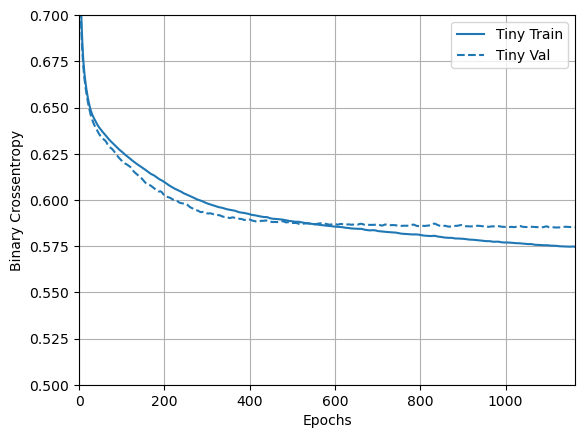

In [50]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [51]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [52]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 753 (2.94 KB)

 Trainable params: 753 (2.94 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4745,  binary_crossentropy:0.8568,  loss:0.8568,  val_accuracy:0.4610,  val_binary_crossentropy:0.7542,  val_loss:0.7542,  
......

2024-08-10 22:08:07.658369: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:07.658412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:07.694804: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:07.694834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:07.731682: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:07.731728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:07.769380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:07.874065: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:07.909279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:07.909333: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:07.946236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:07.946270: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:07.982967: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:07.983014: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:08.092650: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:08.092678: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:08.127120: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:08.127159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:08.161056: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:08.161105: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:08.195612: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:08.300530: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:08.300555: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:08.334480: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:08.334508: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:08.373899: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:08.373947: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:08.408292: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:08.514044: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:08.514095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:08.552248: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:08.552277: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:08.585916: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:08.585942: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:08.621264: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:08.726739: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:08.726788: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:08.764007: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:08.764056: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:08.797556: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:08.797584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:08.829304: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:08.935931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:08.935959: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:08.973511: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:08.973557: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:09.009302: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:09.009332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:09.043347: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:09.152560: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:09.152609: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:09.189778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:09.189806: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:09.224692: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:09.224726: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:09.262205: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:09.373614: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:09.373643: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:09.409707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:09.409743: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:09.442708: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:09.442746: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:09.477502: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:09.579978: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:09.580007: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:09.612507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:09.612537: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:09.645647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:09.645696: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:09.680588: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:09.782585: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:09.817030: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:09.850928: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:09.850971: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:09.886840: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:09.920351: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:09.920380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

......

2024-08-10 22:08:09.987348: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:09.987378: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:10.020555: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:10.020583: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:10.053909: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:10.053938: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:10.091905: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:10.197876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:10.197907: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:10.230740: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:10.230770: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:10.265002: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:10.265035: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:10.297922: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:10.411667: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:10.411697: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:10.447014: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:10.447044: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:10.480794: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:10.480832: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:10.516408: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:10.626697: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:10.626745: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:10.669256: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:10.669308: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:10.708949: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:10.708975: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:10.743618: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:10.855612: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:10.892981: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:10.893034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:10.930902: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:10.930951: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:10.972998: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:10.973025: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

....
Epoch: 100, accuracy:0.6413,  binary_crossentropy:0.6049,  loss:0.6049,  val_accuracy:0.6190,  val_binary_crossentropy:0.6017,  val_loss:0.6017,  
..

2024-08-10 22:08:11.089754: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:11.089786: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:11.122655: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:11.122694: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:11.155658: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:11.191091: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:11.191140: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:11.300341: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:11.300378: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:11.334198: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:11.334238: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:11.373835: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:11.373869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:11.408191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:11.506650: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:11.506678: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:11.541931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:11.541960: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:11.576830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:11.576876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:11.612065: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:11.714659: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:11.714692: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:11.747897: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:11.747928: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:11.781627: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:11.781662: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:11.816880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:11.948888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:11.948926: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:11.984577: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:11.984605: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:12.020037: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:12.020103: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:12.062073: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:12.172943: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:12.172978: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:12.209473: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:12.243187: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:12.243222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:12.279790: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:12.279819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:12.392656: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:12.392709: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:12.426691: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:12.426732: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:12.463326: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:12.463355: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:12.497971: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:12.605195: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:12.605244: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:12.642208: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:12.642255: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:12.680289: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:12.680322: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:12.714408: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:12.814133: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:12.814161: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:12.848204: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:12.848234: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:12.880582: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:12.880615: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:12.912901: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:13.051418: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:13.051450: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:13.087134: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:13.087183: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:13.121231: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:13.121271: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:13.153223: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:13.257452: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:13.257484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:13.291121: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:13.291149: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:13.324703: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:13.324732: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:13.362147: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:13.461477: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:13.461507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:13.498087: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:13.498115: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:13.532829: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:13.532855: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:13.569414: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:13.669691: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:13.703310: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:13.703340: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:13.734719: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:13.734762: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:13.765479: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:13.765524: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:13.897052: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:13.897089: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:13.930961: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:13.930990: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:13.964148: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:13.964175: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:13.999959: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:14.101303: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:14.101345: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:14.135393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:14.135434: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:14.168604: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:14.203467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:14.203515: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:14.306532: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:14.341995: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:14.342036: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:14.376449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:14.376500: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:14.440144: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:14.440175: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....
Epoch: 200, accuracy:0.6698,  binary_crossentropy:0.5880,  loss:0.5880,  val_accuracy:0.6500,  val_binary_crossentropy:0.5840,  val_loss:0.5840,  
..

2024-08-10 22:08:14.539239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:14.539268: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:14.573094: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:14.573122: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:14.609231: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:14.609264: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:14.641479: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:14.742222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:14.742250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:14.777457: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:14.777507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:14.814317: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:14.814369: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:14.848670: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:14.959541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:14.959596: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:14.998424: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:14.998471: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:15.035687: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:15.035734: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:15.070094: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:15.173964: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:15.173991: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:15.213150: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:15.246903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:15.246950: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:15.280291: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:15.280339: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:15.383056: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:15.383086: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:15.417465: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:15.417493: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:15.452041: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:15.452091: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:15.489156: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:15.596927: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:15.596966: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:15.632803: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:15.632831: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:15.667123: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:15.734844: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:15.734875: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:15.803732: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:15.803777: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:15.839110: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:15.839148: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:15.877527: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:15.877555: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:15.916421: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:16.025085: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:16.025132: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:16.063304: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:16.063337: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:16.098251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:16.098277: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:16.133465: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:16.242927: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:16.242976: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:16.280402: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:16.280450: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:16.316893: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:16.316942: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:16.352575: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:16.458362: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:16.493666: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:16.493700: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:16.530133: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:16.530170: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:16.564006: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:16.564036: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:16.668271: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:16.668321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:16.705726: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:16.705774: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:16.740774: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:16.740824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:16.776711: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:16.877376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:16.877422: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:16.912065: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:16.912098: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:16.946912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:16.946964: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:16.978756: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:17.083707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:17.083755: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:17.122080: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:17.122126: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:17.157097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:17.157144: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:17.190512: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:17.292922: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:17.292968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:17.329812: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:17.329845: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:17.366133: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:17.366210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:17.399280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:17.500451: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:17.500483: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:17.534662: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:17.534696: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:17.567337: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:17.567365: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:17.597627: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

........

2024-08-10 22:08:17.735988: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:17.736019: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:17.772687: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:17.772715: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:17.806091: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:17.806122: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:17.839525: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:17.968300: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:17.968330: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:18.000503: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:18.036125: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:18.069616: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:18.069647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:18.102916: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch: 300, accuracy:0.6785,  binary_crossentropy:0.5782,  loss:0.5782,  val_accuracy:0.6720,  val_binary_crossentropy:0.5812,  val_loss:0.5812,  
......

2024-08-10 22:08:18.174992: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:18.175020: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:18.213166: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:18.213215: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:18.246665: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:18.246713: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:18.280060: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:18.383764: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:18.383805: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:18.419164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:18.419200: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:18.455034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:18.455070: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:18.489307: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:18.604004: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:18.604038: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:18.649738: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:18.649789: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:18.688769: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:18.688803: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:18.723019: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:18.835017: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:18.835047: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:18.871955: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:18.871984: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:18.906604: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:18.906638: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:18.939169: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:19.040472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:19.075556: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:19.075593: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:19.109228: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:19.109263: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:19.146541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:19.146589: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:19.246527: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:19.246577: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:19.278038: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:19.307632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:19.307681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:19.343651: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:19.343680: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

........

2024-08-10 22:08:19.478781: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:19.478808: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:19.507619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:19.507649: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:19.542861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:19.542892: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:19.575475: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:19.691206: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:19.691233: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:19.726504: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:19.726557: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:19.759756: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:19.759787: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:19.790109: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:19.915275: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:19.915295: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:19.984022: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:19.984056: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:20.014320: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:20.014359: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:20.052449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:20.118170: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:20.154053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:20.154082: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:20.183888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:20.183915: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:20.213245: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:20.213272: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:20.343589: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:20.343632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:20.377381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:20.377425: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:20.409377: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:20.409412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:20.442859: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:20.572821: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:20.572867: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:20.600404: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:20.600447: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:20.627300: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:20.659604: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:20.689646: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

......

2024-08-10 22:08:20.787519: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:20.787551: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:20.824009: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:20.860351: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:20.860400: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:20.893220: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:20.893249: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:20.992998: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:20.993048: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:21.033061: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:21.070348: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:21.070385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:21.104506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:21.104540: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:21.206293: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:21.206327: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:21.243592: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:21.243620: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:21.276828: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:21.276876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:21.307760: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

....
Epoch: 400, accuracy:0.6841,  binary_crossentropy:0.5710,  loss:0.5710,  val_accuracy:0.6600,  val_binary_crossentropy:0.5821,  val_loss:0.5821,  
....

2024-08-10 22:08:21.445870: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:21.445897: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:21.480717: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:21.480763: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:21.509837: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:21.509880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:21.541900: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:21.667460: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:21.667488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:21.700498: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:21.700545: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:21.734495: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:21.734521: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:21.768435: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:21.901778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:21.901806: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:21.936707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:21.936752: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:21.971833: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:21.971864: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:22.004854: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:22.112165: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:22.112195: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:22.146336: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:22.180764: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:22.180810: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:22.214684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:22.248280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

.......

2024-08-10 22:08:22.350121: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:22.350149: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:22.381471: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:22.381503: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:22.415721: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:22.415758: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:22.449888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:22.552341: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:22.552380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:22.585728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:22.585761: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:22.618974: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:22.619009: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:22.655885: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:22.757830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:22.757868: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:22.788734: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:22.788782: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:22.820452: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:22.820494: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:22.853956: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:22.987347: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:23.025588: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:23.025622: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:23.064791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:23.064858: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:23.096321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:23.096354: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:23.196683: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:23.196713: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:23.226165: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:23.226192: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:23.259734: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:23.259764: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:23.291772: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:23.417358: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:23.417394: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:23.448334: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:23.448381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:23.483450: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:23.483483: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:23.513751: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:23.631566: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:23.631608: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:23.667047: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:23.667080: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:23.696888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:23.696917: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:23.724116: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:23.856236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:23.856295: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:23.890178: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:23.890214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:23.923774: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:23.923802: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:23.957764: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:24.063023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:24.063058: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:24.106425: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:24.106471: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:24.146714: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:24.146746: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:24.186676: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:24.298833: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:24.298866: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:24.334510: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:24.372419: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:24.372456: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:24.407876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:24.407901: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:24.510720: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:24.545231: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:24.545286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:24.579542: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:24.613341: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:24.613391: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:24.643875: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

......

2024-08-10 22:08:24.712810: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:24.712839: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:24.749657: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:24.749695: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:24.782461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:24.782490: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:24.816382: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 


Epoch: 500, accuracy:0.6902,  binary_crossentropy:0.5655,  loss:0.5655,  val_accuracy:0.6660,  val_binary_crossentropy:0.5838,  val_loss:0.5838,  
......

2024-08-10 22:08:24.919315: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:24.919340: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:24.952580: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:24.952610: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:24.991917: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:24.991948: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:25.024800: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:25.128101: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:25.128130: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:25.161074: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:25.197434: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:25.197463: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:25.230536: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:25.230608: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:25.335000: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:25.335025: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:25.371039: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:25.371072: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:25.406862: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:25.406910: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:25.441945: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:25.545553: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:25.545600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:25.582630: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:25.582658: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:25.617233: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:25.617264: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:25.651884: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:25.757209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:25.757241: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:25.793724: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:25.793752: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:25.832641: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:25.866290: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:25.897691: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

......

2024-08-10 22:08:25.966283: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:25.966321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:25.999154: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:25.999193: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:26.035842: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:26.035876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:26.071664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:26.178973: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:26.179019: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:26.214647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:26.251387: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:26.251420: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:26.284747: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:26.284786: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:26.383258: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:26.383285: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:26.422462: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:26.422496: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:26.455451: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:26.455485: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:26.490204: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:26.596159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:26.596195: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:26.630486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:26.662482: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:26.662509: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:26.693988: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:26.694037: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:26.800156: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:26.800218: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:26.836035: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:26.836073: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:26.869955: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:26.869982: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:26.902914: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:27.035531: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:27.035570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:27.079205: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:27.079251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:27.148488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:27.148522: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:27.182885: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:27.246450: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:27.246478: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:27.280033: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:27.280061: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:27.310463: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:27.310522: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:27.345619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:27.458264: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:27.458301: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:27.492787: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:27.492826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:27.528904: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:27.528934: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:27.560990: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:27.661677: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:27.661703: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:27.697295: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:27.697325: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:27.730679: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:27.766845: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:27.766881: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:27.869517: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:27.869545: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:27.903278: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:27.903312: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:27.937870: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:27.937899: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:27.972329: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:28.072576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:28.107030: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:28.107061: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:28.141464: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:28.141511: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:28.173855: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:28.173884: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

In [53]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [54]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,241 (40.00 KB)

 Trainable params: 10,241 (40.00 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4935,  binary_crossentropy:0.6979,  loss:0.6979,  val_accuracy:0.4860,  val_binary_crossentropy:0.6834,  val_loss:0.6834,  
......

2024-08-10 22:08:29.368687: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:29.368742: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:29.411720: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:29.411770: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:29.449249: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:29.449283: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:29.485413: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:29.603051: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:29.603100: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:29.644315: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:29.644344: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:29.680350: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:29.680387: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:29.716016: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:29.823231: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:29.823280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:29.861910: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:29.861940: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:29.896809: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:29.896857: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:29.932892: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:30.039166: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:30.039196: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:30.078362: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:30.078412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:30.119493: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:30.119539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:30.158146: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:30.271451: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:30.307477: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:30.307506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:30.343390: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:30.343430: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:30.378506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:30.378534: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:30.483848: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:30.483897: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:30.522039: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:30.522079: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:30.557704: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:30.557738: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:30.591008: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:30.694969: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:30.695017: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:30.733080: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:30.733128: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:30.767823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:30.767871: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:30.801591: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:30.910341: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:30.910390: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:30.945456: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:30.945486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:30.981830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:30.981877: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:31.018990: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:31.132104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:31.132159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:31.165604: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:31.165652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:31.201525: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:31.201573: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:31.236417: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:31.345119: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:31.345150: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:31.383489: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:31.383536: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:31.417921: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:31.452172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:31.452210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:31.563116: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:31.563144: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:31.598469: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:31.598507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:31.634625: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:31.634664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:31.672103: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:31.777362: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:31.777396: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:31.817371: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:31.817400: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:31.856431: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:31.856462: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:31.890731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:32.000280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:32.000316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:32.037036: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:32.037077: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:32.106287: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:32.106318: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:32.144116: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:32.213041: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:32.213070: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:32.248855: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:32.248884: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:32.284680: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:32.284731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:32.322310: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:32.436619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:32.436669: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:32.473531: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:32.473576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:32.507200: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:32.546236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:32.546264: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:32.656612: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:32.656664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:32.691252: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:32.691302: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:32.732506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:32.732535: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:32.769674: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

....
Epoch: 100, accuracy:0.7108,  binary_crossentropy:0.5341,  loss:0.5341,  val_accuracy:0.6210,  val_binary_crossentropy:0.6332,  val_loss:0.6332,  
..

2024-08-10 22:08:32.879093: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:32.879126: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:32.918015: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:32.918044: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:32.954333: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:32.954378: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:32.990758: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:33.103522: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:33.103551: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:33.140794: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:33.140828: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:33.178655: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:33.178733: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:33.217972: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:33.328740: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:33.328769: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:33.365086: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:33.365133: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:33.401232: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:33.401268: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:33.438237: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:33.584878: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:33.584926: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:33.624323: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:33.624371: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:33.661082: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:33.661110: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:33.697271: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:33.811399: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:33.847903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:33.847935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:33.885961: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:33.886009: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:33.924318: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:33.924367: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:34.038008: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:34.038034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:34.077975: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:34.078002: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:34.114962: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:34.115000: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:34.153798: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:34.277279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:34.277308: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:34.314771: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:34.314810: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:34.351155: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:34.351184: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:34.387417: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:34.500098: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:34.500138: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:34.538730: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:34.538755: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:34.610961: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:34.611000: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:34.649085: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:34.725374: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:34.725414: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:34.765882: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:34.804098: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:34.804143: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:34.844220: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:34.844251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:34.957332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:34.957381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:34.995644: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:34.995690: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:35.035228: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:35.035259: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:35.070711: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:35.187297: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:35.187338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:35.229231: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:35.229281: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:35.267407: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:35.267458: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:35.304172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:35.422851: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:35.422880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:35.459025: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:35.459055: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:35.500750: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:35.500812: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:35.539201: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:35.654239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:35.654272: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:35.690859: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:35.690898: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:35.726859: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:35.726898: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:35.763100: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:35.877702: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:35.877730: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:35.914466: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:35.953928: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:35.953974: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:35.989590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:35.989618: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:36.106047: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:36.106096: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:36.145814: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:36.145851: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:36.182631: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:36.182675: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:36.221308: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:36.377278: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:36.377309: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:36.417499: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:36.417527: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:36.455675: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:36.455728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:36.491319: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:36.605607: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:36.605640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:36.643745: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:36.643785: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:36.680058: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:36.680095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:36.715814: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 


Epoch: 200, accuracy:0.7760,  binary_crossentropy:0.4440,  loss:0.4440,  val_accuracy:0.6270,  val_binary_crossentropy:0.7045,  val_loss:0.7045,  
......

2024-08-10 22:08:36.828872: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:36.828900: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:36.867549: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:36.867597: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:36.903772: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:36.903803: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:36.944630: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:37.060413: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:37.060444: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:37.099896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:37.099945: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:37.137129: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:37.137173: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:37.173138: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:37.288422: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:37.288449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:37.328378: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:37.328407: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:37.369444: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:37.369492: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:37.404828: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:37.520968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:37.521006: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:37.561681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:37.561715: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:37.596653: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:37.596703: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:37.633979: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:37.752326: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:37.752389: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:37.788684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:37.788717: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:37.828439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:37.828472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:37.867132: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:37.990754: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:37.990786: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:38.028821: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:38.028855: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:38.072653: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:38.072700: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:38.113820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

......

2024-08-10 22:08:38.227756: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:38.227797: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:38.267279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:38.303408: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:38.303438: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:38.340306: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:38.340345: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:38.452515: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:38.452557: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:38.497399: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:38.497449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:38.538869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:38.538910: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:38.578484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:38.688799: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:38.688876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:38.728288: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:38.728338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:38.767193: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:38.767221: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:38.803744: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

....

2024-08-10 22:08:38.917315: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:38.917343: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:38.956039: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:38.956079: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:38.993834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:38.993873: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:39.035014: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

In [55]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [56]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5051,  binary_crossentropy:0.8063,  loss:0.8063,  val_accuracy:0.5670,  val_binary_crossentropy:0.6825,  val_loss:0.6825,  
.....

2024-08-10 22:08:40.304288: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:40.304325: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:40.348441: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:40.348470: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:40.394458: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:40.394512: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:40.436425: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:40.522933: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:40.522969: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:40.569471: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:40.569521: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:40.611321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:40.611368: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:40.652981: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:40.740506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:40.740533: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:40.786923: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:40.786959: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:40.828465: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:40.828517: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:40.870383: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:40.955514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.002642: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.002689: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:41.047905: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.047934: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:41.091231: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.091279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.....

2024-08-10 22:08:41.185857: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.185892: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:41.228886: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.228945: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:41.270277: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.270326: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:41.312450: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:41.392306: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.392369: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:41.436840: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.479255: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.520880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.520930: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:41.561449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.....

2024-08-10 22:08:41.603175: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.603215: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:41.645997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.688857: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.688898: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:41.729758: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.729801: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.....

2024-08-10 22:08:41.811961: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.812002: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:41.856626: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.856662: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:41.900364: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:41.900403: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:41.941383: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:42.026056: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:42.026090: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:42.073280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:42.073322: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:42.117684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:42.117715: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:42.157808: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:42.246180: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:42.246210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:42.300639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:42.341311: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:42.341341: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:42.386394: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:42.386446: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.....

2024-08-10 22:08:42.470195: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:42.470249: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:42.514817: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:42.514870: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:42.558126: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:42.558157: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:42.601934: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:42.688611: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:42.688641: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:42.735650: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:42.735690: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:42.777905: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:42.777937: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:42.820416: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:42.904663: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:42.904698: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:42.949371: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:42.949397: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:42.991862: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:43.036244: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:43.036276: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.....

2024-08-10 22:08:43.128062: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:43.128133: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:43.172979: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:43.173008: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:43.220585: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:43.220648: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:43.265632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:43.354382: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:43.354413: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:43.401341: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:43.401389: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:43.443582: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:43.443652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:43.488252: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:43.578015: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:43.578046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:43.624418: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:43.624473: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:43.708329: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:43.708365: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:43.750099: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:43.792678: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:43.792715: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:43.839431: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:43.839461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:43.882117: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:43.882151: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:43.921847: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:44.006342: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:44.055069: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:44.055108: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:44.100393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:44.100421: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:44.141414: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:44.141466: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.....

2024-08-10 22:08:44.235525: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:44.235573: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:44.284012: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:44.284040: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:44.326227: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:44.326265: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:44.368400: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:44.462229: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:44.462261: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:44.549907: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:44.549955: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:44.591469: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:44.634260: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:44.634305: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i


Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0023,  loss:0.0023,  val_accuracy:0.6680,  val_binary_crossentropy:1.7159,  val_loss:1.7159,  
......

2024-08-10 22:08:44.720432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:44.720472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:44.763488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:44.763536: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:44.807331: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:44.807361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:44.847460: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:44.934189: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:44.934228: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:44.976856: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:44.976885: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:45.018407: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:45.018457: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:45.060820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:45.147246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:45.147277: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:45.193973: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:45.194004: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:45.238933: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:45.238967: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:45.280475: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.......

2024-08-10 22:08:45.461975: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:45.462011: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:45.506353: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:45.506404: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:45.549903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:45.549940: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:45.592246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:45.677653: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:45.677686: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:45.723391: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:45.723439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:45.765845: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:45.765895: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:45.809420: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:45.894950: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:45.894983: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:45.980161: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:45.980212: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:46.020291: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:46.020326: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:46.064666: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:46.111636: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:46.111684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:46.157862: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:46.157893: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:46.200244: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:46.200283: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:46.242556: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:46.328871: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:46.328912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:46.378993: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:46.379035: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:46.421184: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:46.421231: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:46.461821: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:46.543683: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:46.543714: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:46.587345: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:46.587385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:46.629911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:46.629945: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:46.670239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:46.754467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:46.754501: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:46.799600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:46.799649: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:46.841965: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:46.841994: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:46.883867: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:46.969656: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:47.015819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:47.015864: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:47.059478: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:47.059506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:47.100690: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:47.100740: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.....

2024-08-10 22:08:47.189484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:47.189514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:47.232935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:47.232965: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:47.273130: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:47.273161: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:47.314929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:47.398080: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:47.398114: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:47.441812: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:47.441853: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:47.484173: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:47.484202: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:47.528581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:47.614394: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:47.614426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:47.698639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:47.698688: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:47.740187: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:47.740215: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:47.783036: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:47.826257: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:47.826286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:47.870631: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:47.870672: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:47.915029: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:47.915077: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:47.960353: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:48.047028: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:48.047061: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:48.090896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:48.090934: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:48.133636: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:48.133668: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:48.177939: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:48.267412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:48.267446: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:48.321689: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:48.365092: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:48.407911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:48.407950: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:48.451290: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.....

2024-08-10 22:08:48.495277: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:48.539028: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:48.539080: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:48.583903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:48.583935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:48.625800: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:48.625833: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.....

2024-08-10 22:08:48.709094: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:48.709135: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:48.756121: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:48.756176: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:48.799281: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:48.799333: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:48.844792: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

..
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6760,  val_binary_crossentropy:2.3552,  val_loss:2.3552,  
...

2024-08-10 22:08:48.936953: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:48.936982: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:48.981535: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:48.981571: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:49.027931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:49.027981: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:49.071776: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:49.163972: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:49.164018: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:49.209021: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:49.209053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:49.298113: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:49.298156: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:49.339454: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:49.384135: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:49.384190: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:49.428004: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:49.428046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:49.471508: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:49.471556: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:49.514576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:49.603789: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:49.603818: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:49.647805: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:49.647853: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:49.736352: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:49.736402: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:49.779686: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:49.824184: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:49.824216: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:49.870215: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:49.870263: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:49.914437: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:49.914485: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:49.958796: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

.....

2024-08-10 22:08:50.046780: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:50.046810: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:50.089908: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:50.089959: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536
2024-08-10 22:08:50.139803: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:50.182220: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:50.182268: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

.

2024-08-10 22:08:50.272562: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9877068990892841511
2024-08-10 22:08:50.272608: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16401316262906027536


Text(0.5, 0, 'Epochs [Log Scale]')

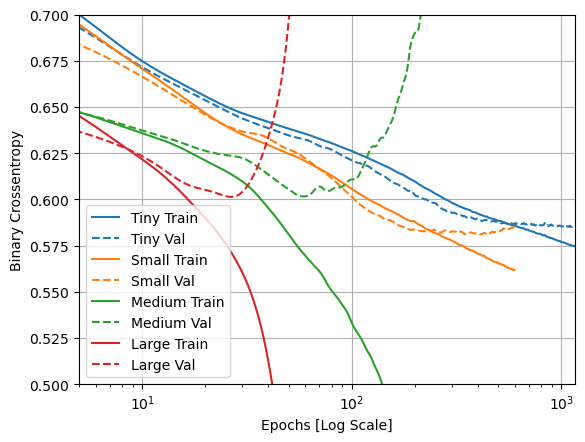

In [57]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [59]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 68563), started 0:00:50 ago. (Use '!kill 68563' to kill it.)

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")